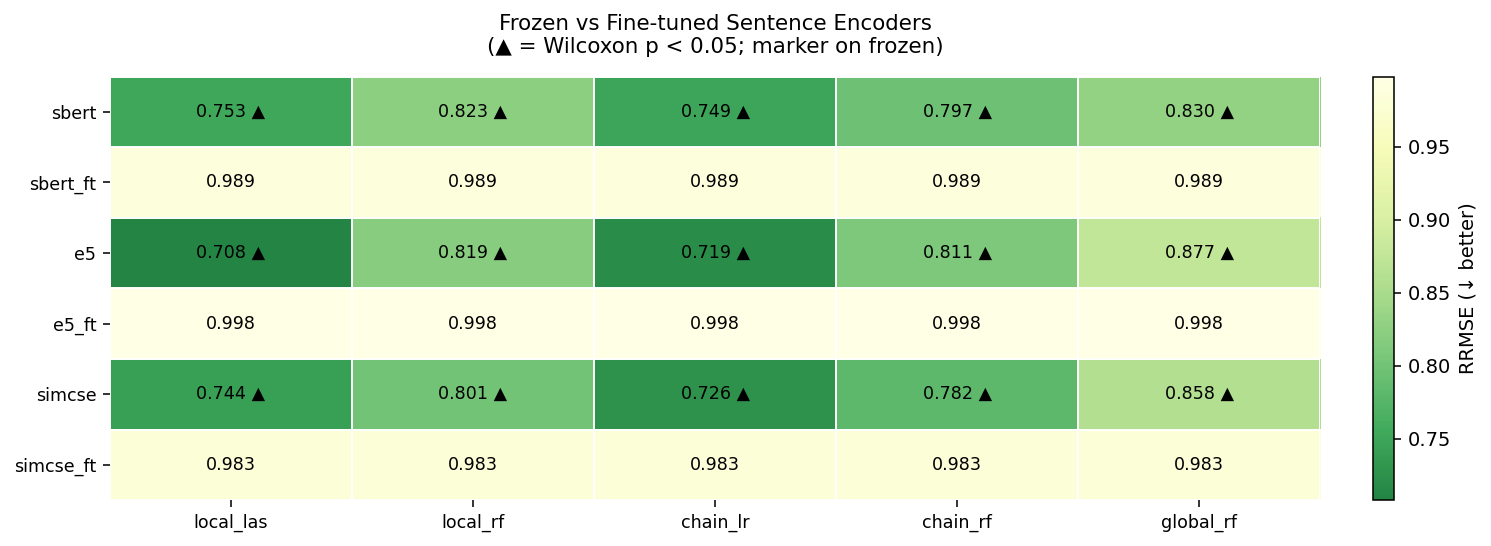

Saved figure → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_4_frozen_vs_finetuned/plots/frozen_vs_ft_heatmap.png


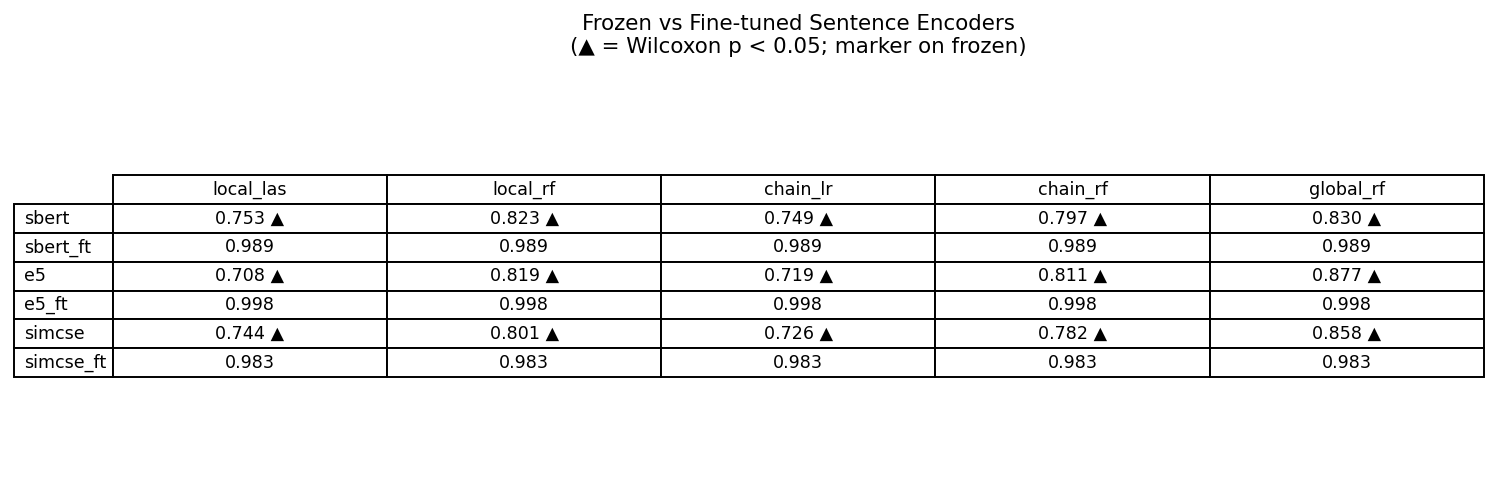

Saved figure → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_4_frozen_vs_finetuned/plots/frozen_vs_ft_table_plain.png


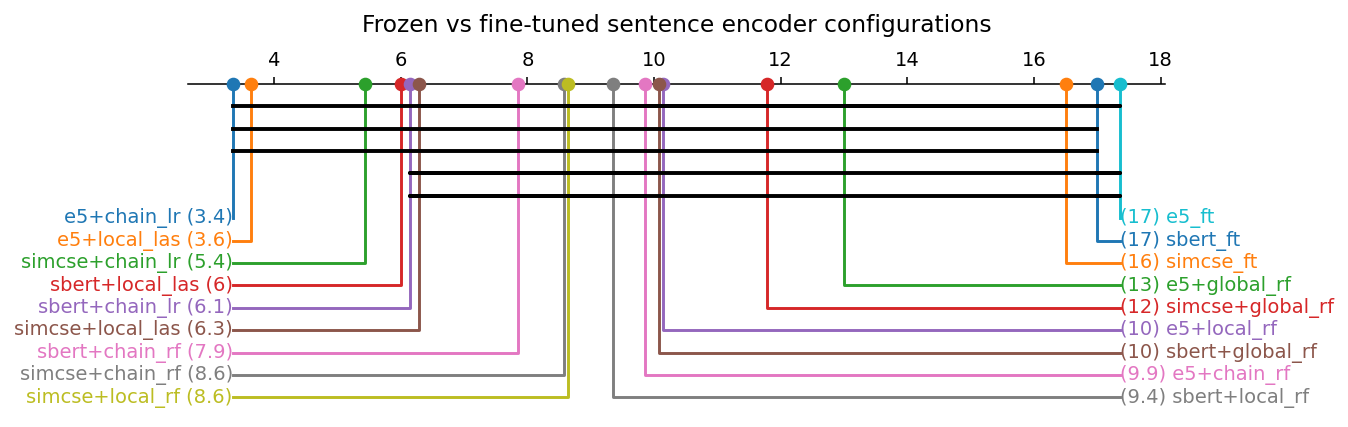

Plot saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_4_frozen_vs_finetuned/plots/CD18_cd.png

Median RRMSE per method (ascending):
e5+local_las        0.708
e5+chain_lr         0.719
simcse+chain_lr     0.726
simcse+local_las    0.744
sbert+chain_lr      0.749
sbert+local_las     0.753
simcse+chain_rf     0.782
sbert+chain_rf      0.797
simcse+local_rf     0.801
e5+chain_rf         0.811
e5+local_rf         0.819
sbert+local_rf      0.823
sbert+global_rf     0.830
simcse+global_rf    0.858
e5+global_rf        0.877
simcse_ft           0.983
sbert_ft            0.989
e5_ft               0.998

Aligned-Friedman (blocks = targets)
  χ²_F = 153.318    F_F = 23.537

Original-Friedman (blocks = targets)
  χ²_F = 153.318    p = 5.48e-24    F_F = 23.537


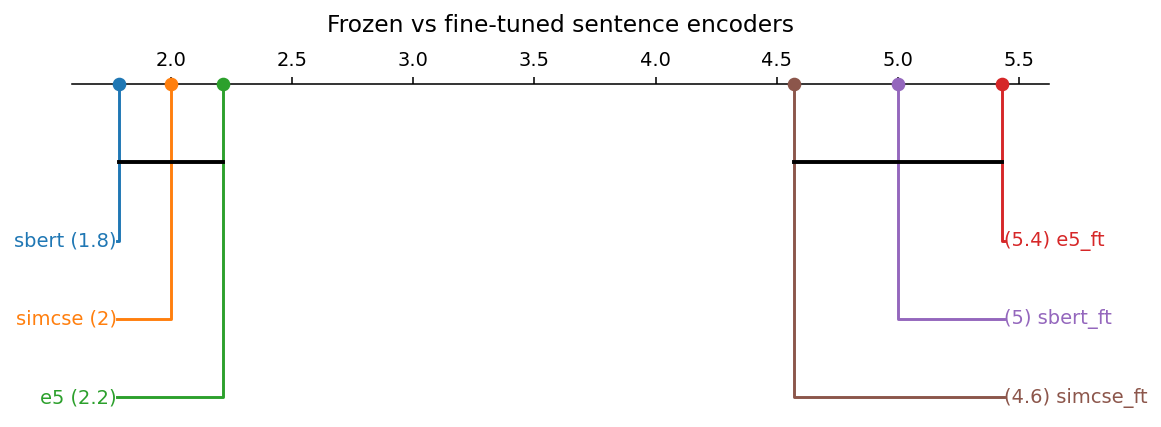

Plot saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_4_frozen_vs_finetuned/plots/CD6_cd.png

Median RRMSE per method (ascending):
simcse       0.782
sbert        0.787
e5           0.789
simcse_ft    0.983
sbert_ft     0.989
e5_ft        0.998

Aligned-Friedman (blocks = targets)
  χ²_F = 55.837    F_F = 51.251

Original-Friedman (blocks = targets)
  χ²_F = 55.837    p = 8.78e-11    F_F = 51.251


In [1]:
"""
f_4_frozen_vs_finetuned.ipynb
───────────────────────────────────────────────────────────────────────────────
Frozen vs Fine-tuned sentence encoders — Wilcoxon heatmap + CD diagrams

Part A: wilcoxon_frozen_vs_ftuned
- Grid (6 rows × 5 columns):
  Rows: sbert, sbert_ft, e5, e5_ft, simcse, simcse_ft
  Cols: local_las, local_rf, chain_lr, chain_rf, global_rf
- Cell value: RRMSE (median_over_targets of per-target fold medians).
- Wilcoxon (two-sided, Pratt) on per-target vectors: frozen vs fine-tuned.
  If p < .05, mark ▲ on the **frozen** row only.
- Saves CSVs (numeric grid, “with triangles”, p-values, significance), PNG
  heatmap and plain table, and LaTeX snippets.

Part B: friedman_frozen_vs_finetuned
- CD diagrams + stats:
  1) 18-method CD = 15 frozen (3 encoders × 5 regressors) + 3 finetuned
  2) 6-method  CD = 3 frozen (aggregated over 5 regressors) + 3 finetuned
- Prints medians, Friedman (original + aligned), Nemenyi p-matrix,
  Wilcoxon pairwise p, Holm-adjusted p, and Cliff’s Δ. Saves CSVs + PNGs.

Inputs:
- outputs/b_frozen/results/{emb_tag}_loocv_rrmse.npy
  (dict: model_key → (folds × 14 targets) RRMSE)
- outputs/d_fine_tuned/results/partial_ft_{emb_tag}_loocv_rrmse.npy
  (dict or array; collapsed to per-target medians)

Outputs (under outputs/f_final_report/f_4_frozen_vs_finetuned/):

tables/
    • rrms e_grid_numeric.csv
    • rrms e_grid_with_triangles.csv
    • pvalues_frozen_vs_ft.csv
    • significance_frozen_vs_finetuned.csv
    • frozen_vs_ft_heatmap.tex
    • frozen_vs_ft_plain.tex
    • CD18_median.csv, CD18_nemenyi_p.csv, CD18_wilcoxon_raw_p.csv,
    • CD18_wilcoxon_holm_p.csv, CD18_cliffs_delta.csv
    • CD6_median.csv,  CD6_nemenyi_p.csv,  CD6_wilcoxon_raw_p.csv,
    • CD6_wilcoxon_holm_p.csv,  CD6_cliffs_delta.csv
plots/
    • frozen_vs_ft_heatmap.png
    • frozen_vs_ft_table_plain.png
    • CD18_cd.png
    • CD6_cd.png
results/
    • included_items_* (lists of included combos, if applicable)
"""

from __future__ import annotations

import os, warnings
from pathlib import Path
from typing import Dict, List, Tuple
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from scipy.stats import wilcoxon, friedmanchisquare
from statsmodels.stats.multitest import multipletests

warnings.filterwarnings("ignore", category=FutureWarning)
np.set_printoptions(suppress=True)

# ─────────────────────────────────────────────────────────────────────────────
# Paths & repo root
# ─────────────────────────────────────────────────────────────────────────────

def get_project_root() -> Path:
    cwd = Path.cwd().resolve()
    for marker in ("environment.yml", "LICENSE"):
        for cand in (cwd, *cwd.parents):
            if (cand / marker).is_file():
                return cand
    return cwd

ROOT = get_project_root()

FROZEN_IN = ROOT / "outputs" / "b_frozen" / "results"
FT_IN     = ROOT / "outputs" / "d_fine_tuned" / "results"

OUT_BASE  = ROOT / "outputs" / "f_final_report" / "f_4_frozen_vs_finetuned"
OUT_TAB   = OUT_BASE / "tables"
OUT_PLOT  = OUT_BASE / "plots"

for d in (OUT_TAB, OUT_PLOT):
    d.mkdir(parents=True, exist_ok=True)

# ─────────────────────────────────────────────────────────────────────────────
# Configuration
# ─────────────────────────────────────────────────────────────────────────────

# (embedding tag on disk, (frozen label, finetuned label))
EMB_ORDER: List[Tuple[str, Tuple[str, str]]] = [
    ("sbert_bert",        ("sbert", "sbert_ft")),
    ("e5_large",          ("e5", "e5_ft")),
    ("simcse_xlmr_base",  ("simcse", "simcse_ft")),
]

# (internal model key in npy dict, short display col label)
MODELS: List[Tuple[str, str]] = [
    ("local_lasso",    "local_las"),
    ("local_rf",       "local_rf"),
    ("chain_ERCcv_lr", "chain_lr"),
    ("chain_ERCcv_rf", "chain_rf"),
    ("global_rf",      "global_rf"),
]

ALPHA = 0.05
TRI   = "▲"
N_TARGETS = 14

# ─────────────────────────────────────────────────────────────────────────────
# Shared helpers (I/O, transforms, ranks, stats)
# ─────────────────────────────────────────────────────────────────────────────

def _safe_load_npy_dict(path: Path):
    obj = np.load(path, allow_pickle=True)
    try:
        return obj.item()
    except Exception:
        return obj

def _per_target_medians(arr: np.ndarray) -> np.ndarray:
    arr = np.asarray(arr)
    if arr.ndim == 2:  # (folds, targets)
        return np.median(arr, axis=0)
    if arr.ndim == 1:  # already per-target
        return arr
    raise ValueError(f"Unexpected shape: {arr.shape}")

def _cell_scalar(vec14: np.ndarray) -> float:
    return float(np.median(np.asarray(vec14)))

def load_frozen_vectors_per_model(emb_tag: str) -> Dict[str, np.ndarray]:
    f = FROZEN_IN / f"{emb_tag}_loocv_rrmse.npy"
    if not f.exists():
        raise FileNotFoundError(f"Missing frozen results: {f}")
    obj = _safe_load_npy_dict(f)
    if not isinstance(obj, dict):
        raise ValueError(f"Expected dict in {f}, got {type(obj)}")
    out = {}
    for m_key, _disp in MODELS:
        if m_key not in obj:
            raise KeyError(f"Model '{m_key}' not found in {f.name}")
        out[m_key] = _per_target_medians(obj[m_key])
    return out

def load_finetuned_vector(emb_tag: str) -> np.ndarray:
    f = FT_IN / f"partial_ft_{emb_tag}_loocv_rrmse.npy"
    if not f.exists():
        raise FileNotFoundError(f"Missing fine-tuned results: {f}")
    obj = _safe_load_npy_dict(f)
    if isinstance(obj, dict):
        arr = obj.get("partial_ft_regressor", None)
        if arr is None:
            arr = next(iter(obj.values())) if len(obj) else None
            if arr is None:
                raise ValueError(f"Empty dict in {f}")
    else:
        arr = obj
    return _per_target_medians(np.asarray(arr))

def aligned_ranks(mat: np.ndarray) -> np.ndarray:
    aligned = mat - np.median(mat, axis=1, keepdims=True)
    return np.apply_along_axis(lambda r: np.argsort(np.argsort(r)) + 1, 1, aligned)

def friedman_aligned(ranks: np.ndarray) -> Tuple[float, float]:
    n, k = ranks.shape
    chi2, _ = friedmanchisquare(*[ranks[:, i] for i in range(k)])
    Ff = ((n - 1) * chi2) / (n * (k - 1) - chi2)
    return chi2, Ff

def wilcoxon_matrix(mat: np.ndarray, labels: List[str]) -> pd.DataFrame:
    df = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)
    for i, j in combinations(range(len(labels)), 2):
        diff = mat[:, i] - mat[:, j]
        p = 1.0 if np.allclose(diff, 0) else wilcoxon(diff, zero_method="zsplit")[1]
        df.iat[i, j] = df.iat[j, i] = p
    np.fill_diagonal(df.values, 1.0)
    return df

def holm_correct_and_effects(raw_p: pd.DataFrame, data: np.ndarray, labels: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    idx = list(combinations(range(len(labels)), 2))
    pvals = [float(raw_p.iat[i, j]) for i, j in idx]
    _, p_adj, _, _ = multipletests(pvals, method="holm")
    adj = raw_p.copy()
    for (i, j), p in zip(idx, p_adj):
        adj.iat[i, j] = adj.iat[j, i] = p
    np.fill_diagonal(adj.values, 1.0)

    def cliffs_delta(x, y):
        diffs = np.subtract.outer(x, y)
        n = diffs.size
        return (np.sum(diffs > 0) - np.sum(diffs < 0)) / n

    delta = pd.DataFrame(np.zeros_like(raw_p.values, dtype=float), index=labels, columns=labels)
    for (i, j) in idx:
        d = cliffs_delta(data[:, i], data[:, j])
        delta.iat[i, j] = d
        delta.iat[j, i] = -d
    return adj.round(6), delta.round(3)

# ─────────────────────────────────────────────────────────────────────────────
# Part A — wilcoxon_frozen_vs_ftuned (heatmap + tables)
# ─────────────────────────────────────────────────────────────────────────────

def get_lightened_cmap(minfrac: float = 0.25):
    base = plt.get_cmap("YlGn_r", 256)
    return mpl.colors.LinearSegmentedColormap.from_list(
        "YlGn_r_trunc", base(np.linspace(minfrac, 1.0, 256))
    )

def compute_grids() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    row_labels = []
    col_labels = [disp for _k, disp in MODELS]

    numeric_rows, display_rows, pval_rows, sig_rows = [], [], [], []

    for emb_tag, (row_name_frozen, row_name_ft) in EMB_ORDER:
        frozen_per_model = load_frozen_vectors_per_model(emb_tag)
        ft_vec = load_finetuned_vector(emb_tag)

        # frozen row
        row_labels.append(row_name_frozen)
        nums, disps, pvs, sgs = [], [], [], []
        for m_key, _m_disp in MODELS:
            froz_vec = frozen_per_model[m_key]
            v = _cell_scalar(froz_vec)
            if np.allclose(froz_vec - ft_vec, 0):
                p = 1.0
            else:
                _, p = wilcoxon(froz_vec, ft_vec, zero_method="pratt", alternative="two-sided", method="auto")
            sig = bool(p < ALPHA)
            nums.append(v)
            disps.append(f"{v:.3f}" + (f" {TRI}" if sig else ""))
            pvs.append(float(p))
            sgs.append(sig)
        numeric_rows.append(nums)
        display_rows.append(disps)
        pval_rows.append(pvs)
        sig_rows.append(sgs)

        # fine-tuned row
        row_labels.append(row_name_ft)
        vft = _cell_scalar(ft_vec)
        numeric_rows.append([vft] * len(MODELS))
        display_rows.append([f"{vft:.3f}"] * len(MODELS))
        pval_rows.append([np.nan] * len(MODELS))
        sig_rows.append([False] * len(MODELS))

    values_df_num  = pd.DataFrame(numeric_rows, index=row_labels, columns=col_labels)
    values_df_disp = pd.DataFrame(display_rows, index=row_labels, columns=col_labels)
    pvals_df       = pd.DataFrame(pval_rows,   index=row_labels, columns=col_labels)
    signif_df      = pd.DataFrame(sig_rows,    index=row_labels, columns=col_labels)
    return values_df_num, values_df_disp, pvals_df, signif_df

def plot_heatmap(values_df_num: pd.DataFrame, signif_df: pd.DataFrame, png_path: Path):
    fig, ax = plt.subplots(figsize=(10.8, 4.0), dpi=140)
    V = values_df_num.values.astype(float)
    vmin, vmax = float(np.nanmin(V)), float(np.nanmax(V))
    im = ax.imshow(V, aspect="auto", vmin=vmin, vmax=vmax, cmap=get_lightened_cmap(0.25))

    ax.set_xticks(np.arange(values_df_num.shape[1]))
    ax.set_xticklabels(values_df_num.columns, fontsize=9)
    ax.set_yticks(np.arange(values_df_num.shape[0]))
    ax.set_yticklabels(values_df_num.index, fontsize=9)

    for i in range(values_df_num.shape[0] + 1):
        ax.axhline(i - 0.5, color="white", lw=1)
    for j in range(values_df_num.shape[1] + 1):
        ax.axvline(j - 0.5, color="white", lw=1)

    for i in range(values_df_num.shape[0]):
        is_frozen_row = (i % 2 == 0)
        for j in range(values_df_num.shape[1]):
            num = f"{values_df_num.iat[i, j]:.3f}"
            txt = num + (f" {TRI}" if (is_frozen_row and bool(signif_df.iat[i, j])) else "")
            ax.text(j, i, txt, ha="center", va="center", fontsize=9, color="black")

    cbar = fig.colorbar(im, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label("RRMSE (↓ better)")

    ax.set_title("Frozen vs Fine-tuned Sentence Encoders\n(▲ = Wilcoxon p < 0.05; marker on frozen)",
                 fontsize=11, pad=12)
    for s in ("top", "right", "left", "bottom"):
        ax.spines[s].set_visible(False)

    plt.tight_layout()
    fig.savefig(png_path, bbox_inches="tight")
    plt.show()
    print(f"Saved figure → {png_path}")

def plot_table_plain(values_df_disp: pd.DataFrame, png_path: Path):
    fig, ax = plt.subplots(figsize=(10.8, 3.6), dpi=140)
    ax.axis("off")
    table = ax.table(
        cellText=values_df_disp.values,
        rowLabels=values_df_disp.index,
        colLabels=values_df_disp.columns,
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.0, 1.2)
    ax.set_title("Frozen vs Fine-tuned Sentence Encoders\n(▲ = Wilcoxon p < 0.05; marker on frozen)",
                 fontsize=11, pad=12)
    plt.tight_layout()
    fig.savefig(png_path, bbox_inches="tight")
    plt.show()
    print(f"Saved figure → {png_path}")

def _hex_from_val(val: float, vmin: float, vmax: float) -> str:
    cm = get_lightened_cmap(0.25)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba = cm(norm(val))
    rgb = tuple(int(round(255*x)) for x in rgba[:3])
    return "{:02X}{:02X}{:02X}".format(*rgb)

def latex_heatmap(values_df_num: pd.DataFrame, signif_df: pd.DataFrame) -> str:
    vmin = float(np.nanmin(values_df_num.values))
    vmax = float(np.nanmax(values_df_num.values))
    lines = []
    lines.append("% Auto-generated: wilcoxon_frozen_vs_ftuned heatmap")
    lines.append("% Requires: \\usepackage{booktabs} \\usepackage[table]{xcolor} \\usepackage{amssymb}")
    lines.append("\\newcommand{\\sig}{\\raisebox{0.35ex}{\\tiny$\\blacktriangle$}}")
    lines.append("\\begin{table}[t]\\centering\\small")
    lines.append("\\setlength\\tabcolsep{6pt}\\renewcommand{\\arraystretch}{1.12}")
    lines.append("\\begin{tabular}{l" + "c"*values_df_num.shape[1] + "}\\toprule")
    lines.append(" & " + " & ".join([f"\\texttt{{{c}}}" for c in values_df_num.columns]) + " \\\\")
    lines.append("\\midrule")
    for i, row in enumerate(values_df_num.index):
        is_frozen = (i % 2 == 0)
        cells = []
        for col in values_df_num.columns:
            val = float(values_df_num.loc[row, col])
            hexcol = _hex_from_val(val, vmin, vmax)
            mark = ("\\sig" if (is_frozen and bool(signif_df.loc[row, col])) else "")
            cells.append(f"\\cellcolor[HTML]{{{hexcol}}}{val:.3f}{mark}")
        lines.append("\\texttt{" + row.replace("_", "\\_") + "} & " + " & ".join(cells) + " \\\\")
    lines.append("\\bottomrule")
    lines.append("\\caption{Frozen vs Fine-tuned Sentence Encoders "
                 "(\\(\\blacktriangle\\) marks Wilcoxon $p<0.05$ for frozen vs fine-tuned).}")
    lines.append("\\label{tab:frozen_vs_ft_heatmap}")
    lines.append("\\end{tabular}\\end{table}")
    return "\n".join(lines)

def latex_plain(values_df_disp: pd.DataFrame) -> str:
    lines = []
    lines.append("% Auto-generated: wilcoxon_frozen_vs_ftuned plain table")
    lines.append("% Requires: \\usepackage{booktabs} \\usepackage{amssymb}")
    lines.append("\\begin{table}[t]\\centering\\small")
    lines.append("\\setlength\\tabcolsep{6pt}\\renewcommand{\\arraystretch}{1.12}")
    lines.append("\\begin{tabular}{l" + "c"*values_df_disp.shape[1] + "}\\toprule")
    lines.append(" & " + " & ".join([f"\\texttt{{{c}}}" for c in values_df_disp.columns]) + " \\\\")
    lines.append("\\midrule")
    for row in values_df_disp.index:
        cells = [val.replace("▲", "\\(\\blacktriangle\\)") for val in values_df_disp.loc[row].tolist()]
        lines.append("\\texttt{" + row.replace("_", "\\_") + "} & " + " & ".join(cells) + " \\\\")
    lines.append("\\bottomrule")
    lines.append("\\caption{Frozen vs Fine-tuned Sentence Encoders "
                 "(\\(\\blacktriangle\\) marks Wilcoxon $p<0.05$ for frozen vs fine-tuned).}")
    lines.append("\\label{tab:frozen_vs_ft_plain}")
    lines.append("\\end{tabular}\\end{table}")
    return "\n".join(lines)

def wilcoxon_frozen_vs_ftuned():
    values_df_num, values_df_disp, pvals_df, signif_df = compute_grids()

    (OUT_TAB / "rrmse_grid_numeric.csv").write_text(values_df_num.to_csv(float_format="%.6f"), encoding="utf-8")
    (OUT_TAB / "rrmse_grid_with_triangles.csv").write_text(values_df_disp.to_csv(), encoding="utf-8")
    (OUT_TAB / "pvalues_frozen_vs_ft.csv").write_text(pvals_df.to_csv(float_format="%.6f"), encoding="utf-8")
    (OUT_TAB / "significance_frozen_vs_finetuned.csv").write_text(signif_df.to_csv(), encoding="utf-8")

    (OUT_TAB / "frozen_vs_ft_heatmap.tex").write_text(latex_heatmap(values_df_num, signif_df), encoding="utf-8")
    (OUT_TAB / "frozen_vs_ft_plain.tex").write_text(latex_plain(values_df_disp), encoding="utf-8")

    plot_heatmap(values_df_num, signif_df, OUT_PLOT / "frozen_vs_ft_heatmap.png")
    plot_table_plain(values_df_disp, OUT_PLOT / "frozen_vs_ft_table_plain.png")

# ─────────────────────────────────────────────────────────────────────────────
# Part B — friedman_frozen_vs_finetuned (CDs + stats)
# ─────────────────────────────────────────────────────────────────────────────

def cd_plot(matrix: np.ndarray, labels: List[str], title: str, fname: str):
    if matrix.shape[1] < 2:
        print(f"Skipping CD-plot '{title}' (need ≥2 methods, got {matrix.shape[1]})")
        return
    ranks = aligned_ranks(matrix)
    pvals = sp.posthoc_nemenyi_friedman(ranks)
    if not isinstance(pvals, pd.DataFrame):
        pvals = pd.DataFrame(pvals)
    pvals = pvals.fillna(1.0)
    np.fill_diagonal(pvals.values, 1.0)
    pvals.values[:] = np.minimum(pvals.values, pvals.values.T)

    fig, ax = plt.subplots(figsize=(9, 3.2), dpi=140)
    sp.critical_difference_diagram(pd.Series(ranks.mean(0), index=labels), pvals, ax=ax)
    ax.set_title(title, pad=10)
    fig.savefig(OUT_PLOT / fname, bbox_inches="tight", dpi=300)
    plt.show()
    print(f"Plot saved → {OUT_PLOT / fname}")

def run_friedman_block(mat: np.ndarray, block_name: str, col_labels: List[str], fname_tag: str):
    k = len(col_labels)
    nblocks = mat.shape[0]

    # Medians
    col_meds = pd.Series(np.median(mat, axis=0), index=col_labels)
    (OUT_TAB / f"{fname_tag}_median.csv").write_text(col_meds.to_csv(header=["median_rrmse"]), encoding="utf-8")
    print("\nMedian RRMSE per method (ascending):")
    print(col_meds.sort_values().round(3).to_string())

    # If only 2 methods, just paired Wilcoxon
    if k == 2:
        p = wilcoxon(mat[:, 0], mat[:, 1], zero_method="zsplit")[1]
        print(f"\nPaired Wilcoxon ({col_labels[0]} vs {col_labels[1]}): p = {p:.5g}")
        return

    # Friedman (aligned + original)
    ranks = aligned_ranks(mat)
    chi2_a, Ff_a = friedman_aligned(ranks)
    chi2_o, p_o = friedmanchisquare(*[mat[:, i] for i in range(k)])
    Ff_o = ((nblocks - 1) * chi2_o) / (nblocks * (k - 1) - chi2_o)

    print(f"\nAligned-Friedman (blocks = {block_name})")
    print(f"  χ²_F = {chi2_a:.3f}    F_F = {Ff_a:.3f}")
    print(f"\nOriginal-Friedman (blocks = {block_name})")
    print(f"  χ²_F = {chi2_o:.3f}    p = {p_o:.3g}    F_F = {Ff_o:.3f}")

    # Nemenyi (aligned ranks)
    p_nem = sp.posthoc_nemenyi_friedman(ranks)
    if not isinstance(p_nem, pd.DataFrame):
        p_nem = pd.DataFrame(p_nem)
    p_nem.index = p_nem.columns = col_labels
    (OUT_TAB / f"{fname_tag}_nemenyi_p.csv").write_text(p_nem.to_csv(), encoding="utf-8")

    # Pairwise Wilcoxon + Holm + Cliff's Δ
    wilc = wilcoxon_matrix(mat, col_labels)
    (OUT_TAB / f"{fname_tag}_wilcoxon_raw_p.csv").write_text(wilc.to_csv(), encoding="utf-8")
    adj, delta = holm_correct_and_effects(wilc, mat, col_labels)
    (OUT_TAB / f"{fname_tag}_wilcoxon_holm_p.csv").write_text(adj.to_csv(), encoding="utf-8")
    (OUT_TAB / f"{fname_tag}_cliffs_delta.csv").write_text(delta.to_csv(), encoding="utf-8")

def build_matrix_18() -> Tuple[np.ndarray, List[str]]:
    cols, labels = [], []
    for emb_tag, (lbl_frozen, lbl_ft) in EMB_ORDER:
        frozen = load_frozen_vectors_per_model(emb_tag)
        for m_key, m_disp in MODELS:
            cols.append(frozen[m_key])
            labels.append(f"{lbl_frozen}+{m_disp}")
        ft_vec = load_finetuned_vector(emb_tag)
        cols.append(ft_vec)
        labels.append(lbl_ft)
    mat = np.column_stack(cols)  # (targets × 18)
    return mat, labels

def build_matrix_6() -> Tuple[np.ndarray, List[str]]:
    cols, labels = [], []
    for emb_tag, (lbl_frozen, lbl_ft) in EMB_ORDER:
        frozen = load_frozen_vectors_per_model(emb_tag)
        stack = np.column_stack([frozen[m_key] for m_key, _ in MODELS])  # (targets × 5)
        agg_vec = np.median(stack, axis=1)
        cols.append(agg_vec); labels.append(lbl_frozen)
    for emb_tag, (_lbl_frozen, lbl_ft) in EMB_ORDER:
        cols.append(load_finetuned_vector(emb_tag)); labels.append(lbl_ft)
    mat = np.column_stack(cols)  # (targets × 6)
    return mat, labels

def friedman_frozen_vs_ftuned():
    # 18-method block
    mat18, labels18 = build_matrix_18()
    cd_plot(mat18, labels18, "Frozen vs fine-tuned sentence encoder configurations", "CD18_cd.png")
    run_friedman_block(mat18, "targets", labels18, "CD18")

    # 6-method block
    mat6, labels6 = build_matrix_6()
    cd_plot(mat6, labels6, "Frozen vs fine-tuned sentence encoders", "CD6_cd.png")
    run_friedman_block(mat6, "targets", labels6, "CD6")

# ─────────────────────────────────────────────────────────────────────────────
# Main
# ─────────────────────────────────────────────────────────────────────────────

if __name__ == "__main__":
    # Part A
    wilcoxon_frozen_vs_ftuned()
    # Part B
    friedman_frozen_vs_ftuned()
